# 简介

## huggingface **Image Classification** Demo

| 参数       | 值                                   |
|------------|--------------------------------------|
| 模型       | `google/vit-base-patch16-224-in21k` |
| 数据集     | `food101` 子集 (train[:5000])       |

> https://huggingface.co/docs/transformers/main/en/tasks/image_classification#train

In [ ]:
%pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

In [ ]:
%pip install tensorboard

# 数据集

## load dataset

food101是Parquet,

In [ ]:
from datasets import load_dataset

# 启用流式加载
food_stream = load_dataset("food101", split="train", streaming=True)

# 获取前 5000 条数据
food_list = [example for _, example in zip(range(5000), food_stream)]

# 转换为 Hugging Face 数据集格式
from datasets import Dataset
food = Dataset.from_list(food_list)

# 切分为训练集和测试集
food = food.train_test_split(test_size=0.2)

print(food)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})


example

In [11]:
food["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x333>,
 'label': 53}

## label to id

In [17]:
label_mapping= {
  "apple_pie": 0,
  "baby_back_ribs": 1,
  "baklava": 2,
  "beef_carpaccio": 3,
  "beef_tartare": 4,
  "beet_salad": 5,
  "beignets": 6,
  "bibimbap": 7,
  "bread_pudding": 8,
  "breakfast_burrito": 9,
  "bruschetta": 10,
  "caesar_salad": 11,
  "cannoli": 12,
  "caprese_salad": 13,
  "carrot_cake": 14,
  "ceviche": 15,
  "cheesecake": 16,
  "cheese_plate": 17,
  "chicken_curry": 18,
  "chicken_quesadilla": 19,
  "chicken_wings": 20,
  "chocolate_cake": 21,
  "chocolate_mousse": 22,
  "churros": 23,
  "clam_chowder": 24,
  "club_sandwich": 25,
  "crab_cakes": 26,
  "creme_brulee": 27,
  "croque_madame": 28,
  "cup_cakes": 29,
  "deviled_eggs": 30,
  "donuts": 31,
  "dumplings": 32,
  "edamame": 33,
  "eggs_benedict": 34,
  "escargots": 35,
  "falafel": 36,
  "filet_mignon": 37,
  "fish_and_chips": 38,
  "foie_gras": 39,
  "french_fries": 40,
  "french_onion_soup": 41,
  "french_toast": 42,
  "fried_calamari": 43,
  "fried_rice": 44,
  "frozen_yogurt": 45,
  "garlic_bread": 46,
  "gnocchi": 47,
  "greek_salad": 48,
  "grilled_cheese_sandwich": 49,
  "grilled_salmon": 50,
  "guacamole": 51,
  "gyoza": 52,
  "hamburger": 53,
  "hot_and_sour_soup": 54,
  "hot_dog": 55,
  "huevos_rancheros": 56,
  "hummus": 57,
  "ice_cream": 58,
  "lasagna": 59,
  "lobster_bisque": 60,
  "lobster_roll_sandwich": 61,
  "macaroni_and_cheese": 62,
  "macarons": 63,
  "miso_soup": 64,
  "mussels": 65,
  "nachos": 66,
  "omelette": 67,
  "onion_rings": 68,
  "oysters": 69,
  "pad_thai": 70,
  "paella": 71,
  "pancakes": 72,
  "panna_cotta": 73,
  "peking_duck": 74,
  "pho": 75,
  "pizza": 76,
  "pork_chop": 77,
  "poutine": 78,
  "prime_rib": 79,
  "pulled_pork_sandwich": 80,
  "ramen": 81,
  "ravioli": 82,
  "red_velvet_cake": 83,
  "risotto": 84,
  "samosa": 85,
  "sashimi": 86,
  "scallops": 87,
  "seaweed_salad": 88,
  "shrimp_and_grits": 89,
  "spaghetti_bolognese": 90,
  "spaghetti_carbonara": 91,
  "spring_rolls": 92,
  "steak": 93,
  "strawberry_shortcake": 94,
  "sushi": 95,
  "tacos": 96,
  "takoyaki": 97,
  "tiramisu": 98,
  "tuna_tartare": 99,
  "waffles": 100
}

In [29]:
labels=list(label_mapping.keys())
label2id = {label: str(id) for label, id in label_mapping.items()}
id2label = {str(id): label for label, id in label_mapping.items()}
id2label[str(79)]


'prime_rib'

## preprocess

In [20]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

d:\condaEnv\neurips\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zncyxiong\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is

### apply custom transformations

In [21]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [22]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [23]:
# Apply the transforms to the dataset
food = food.with_transform(transforms)

DefaultDataCollator 的主要功能是：

- 将数据集中的样本打包成批次。
- 自动将样本中的张量（torch.Tensor）堆叠成批次张量。
- 如果样本中包含非张量数据（如字符串或其他类型），它会将这些数据保留为列表。

In [24]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# evaluate

In [25]:
import evaluate

accuracy = evaluate.load("accuracy")

In [27]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# train

In [30]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False, #It is important you don’t remove unused columns because that’ll drop the image column. 
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4, #梯度累积步数，设置为 4，表示在执行一次反向传播之前，会累积 4 个批次的梯度。这对于显存有限的设备非常有用
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1, #预热比例，表示在训练的前 10% 的迭代中，学习率将线性增加到初始学习率
    logging_steps=10,
    load_best_model_at_end=True,# 是否在训练结束时加载最佳模型
    metric_for_best_model="accuracy",
    push_to_hub=False, #是否将模型推送到 Hugging Face Hub
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.696500,2.478717,0.841000
2,1.606300,1.608874,0.884000


TrainOutput(global_step=186, training_loss=2.405743439992269, metrics={'train_runtime': 1080.1216, 'train_samples_per_second': 11.11, 'train_steps_per_second': 0.172, 'total_flos': 9.18319264579584e+17, 'train_loss': 2.405743439992269, 'epoch': 2.96})

# inference

In [33]:
# 启用流式加载
food_stream_val = load_dataset("food101", split="validation", streaming=True)

# 获取前 10 条数据
food_list_val = [example for _, example in zip(range(10), food_stream)]

# 转换为 Hugging Face 数据集格式
from datasets import Dataset
ds = Dataset.from_list(food_list_val)
image = ds["image"][0]

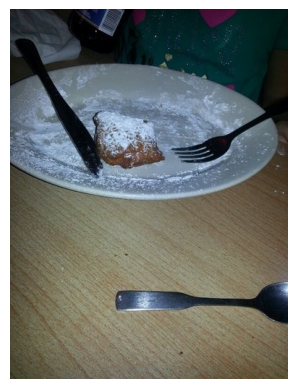

In [36]:
from matplotlib import pyplot as plt

plt.imshow(image)
plt.axis('off')  # 隐藏坐标轴
plt.show()

## use pipline

In [ ]:
from transformers import pipeline

# Save the model if not already saved
model.save_pretrained("my_awesome_food_model") #load_best_model_at_end=True
image_processor.save_pretrained("my_awesome_food_model")

# Load the model using the pipeline
classifier = pipeline("image-classification", model="my_awesome_food_model")
result = classifier(image)
print(result)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'label': 'beignets', 'score': 0.9664458632469177}, {'label': 'prime_rib', 'score': 0.6406794190406799}, {'label': 'bruschetta', 'score': 0.6406086087226868}, {'label': 'ramen', 'score': 0.6359280943870544}, {'label': 'hamburger', 'score': 0.6262603402137756}]


## use pytorch

In [37]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model")
inputs = image_processor(image, return_tensors="pt")

In [38]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model")
with torch.no_grad():
    logits = model(**inputs).logits

In [39]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'

# tensorboard

In [44]:
%load_ext tensorboard

In [45]:
%tensorboard --logdir=my_awesome_food_model/runs